# Закономерности успешности игр

Интернет-магазине «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). В этом проекте нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import math
import numpy as np
from scipy import stats as st

pd.set_option('mode.chained_assignment', None)

import warnings

warnings.filterwarnings('ignore')

In [2]:
games = pd.read_csv('/datasets/games.csv', sep = ',')
display(games.sample(5))
games.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16365,Kurogane Kaikitan,PSV,2015.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
13113,Shiren the Wanderer 5 Plus: Fortune Tower and ...,PSV,2015.0,Action,0.01,0.00,0.04,0.00,NaN,NaN,NaN
14995,MAPLUS: Portable Navi 3,PSP,2009.0,Misc,0.00,0.00,0.02,0.00,NaN,NaN,NaN
12177,Junior Classic Books & Fairytales,DS,2010.0,Misc,0.05,0.01,0.00,0.01,NaN,NaN,NaN
13844,Durarara!! 3way Standoff: Alley,PSP,2011.0,Adventure,0.00,0.00,0.04,0.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Нам дана таблица на 16715 строк

Описание данных

Name — название игры - строковый тип данных, значения пропущены в двух строках

Platform — платформа - строковый тип данных, нет пропущенных данных

Year_of_Release — год выпуска - числа с плавающей точкой, есть пропущенные данные

Genre — жанр игры - строковый тип данных, значения пропущены в двух строках

NA_sales — продажи в Северной Америке (миллионы проданных копий) - числа с плавающей точкой, нет пропущенных данных

EU_sales — продажи в Европе (миллионы проданных копий) - числа с плавающей точкой, нет пропущенных данных

JP_sales — продажи в Японии (миллионы проданных копий) - числа с плавающей точкой, нет пропущенных данных

Other_sales — продажи в других странах (миллионы проданных копий) - числа с плавающей точкой, нет пропущенных данных

Critic_Score — оценка критиков (максимум 100) - числа с плавающей точкой, много пропущенных данных

User_Score — оценка пользователей (максимум 10) - строковый тип данных, много пропущенных данных

Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

## Подготовка данных

Напишем названия всех столбцов в нижнем регистре.
Удалим строки с пропущенными названиями игр и пропущенными годами выпуска, так как это основополагающие для нас данные, пропусков тут быть не должно. При этом пропущенных данный в этих столбцах мало, это не должно повлиять на дальнейшие выводы.
Зименим тип данных в столбце с годом выпуска на целый. Дробный год - это странно.

In [3]:
games.columns = games.columns.str.lower()
games.dropna(subset=['name', 'year_of_release'], inplace=True)
games['year_of_release'] = games['year_of_release'].astype('int')
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


In [4]:
games.duplicated().sum()

0

In [5]:
display(games['user_score'].value_counts())
games['user_score'].isna().sum()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.2       2
1.3       2
0.9       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

6605

Дубликатов в таблице нет.
В столбце с рейтингом пользователей 6605 пропусков и 2376 раз встречается "tbd", что обозначает "To be determed", то есть пользователь ещё не определился с рейтингом. Пропущенных данных много, данных от неопределившихся пользователей тоже много, поэтому оставим их все. Только заменим "tbd" на NaN, и поменяем тип данных на числовой.

In [6]:
games['user_score'] = games['user_score'].replace('tbd', None)
games['user_score'] = pd.to_numeric(games['user_score'])
display(games['user_score'].value_counts())
games['user_score'].isna().sum()

7.8    384
8.2    329
8.0    325
7.5    291
8.3    290
      ... 
0.5      2
1.1      2
1.0      2
2.3      2
0.0      1
Name: user_score, Length: 95, dtype: int64

7834

In [7]:
display(games['critic_score'].value_counts())
games['critic_score'].isna().sum()

70.0    252
71.0    248
75.0    240
80.0    235
73.0    234
       ... 
29.0      3
20.0      3
13.0      1
17.0      1
21.0      1
Name: critic_score, Length: 81, dtype: int64

8461

In [8]:
display(games['rating'].value_counts())
games['rating'].isna().sum()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

6676

Пропущенных данных с рейтингом и с оценками критиков тоже много, эти данные оставляем

In [9]:
games['total_sales'] = games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       8610 non-null   float64
 10  rating           9768 non-null   object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


### Вывод 

Теперь у нас есть таблица на 16444 строк, в которой имеются пропущенные значения только в столбцах с данными по рейтингу. Появился новый столбец, в котором указываются суммарные продажи по всем регионам.

## Исследовательский анализ данных

### Данные по продажам игр по годам

In [10]:
games.groupby('year_of_release')['name'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

Видим, что с 1980 по 1993 годы в год выпускалось не более 60 игр. С 1994 года начался рост в производстве игр, пик которого пришелся на 2009 год. После чего количество производимых игр в год начало сокращаться, и в период с 2012 по 2016 годы производилось по 500-600 игр в год.
Данные с 1980 по 2011 можно не брать в расчёт. Возьмём данные за последнее десятилетие.

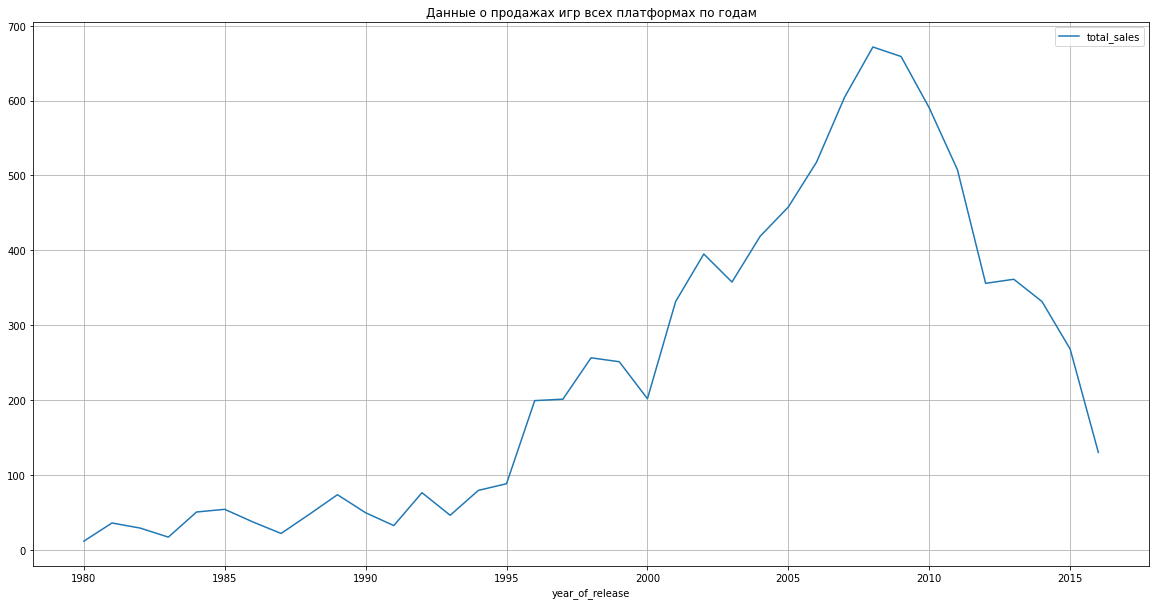

In [11]:
(games
.pivot_table(index=['year_of_release'], values = ['total_sales'], aggfunc='sum')
.plot(grid=True, figsize=(20, 10), title = 'Данные о продажах игр всех платформах по годам'));

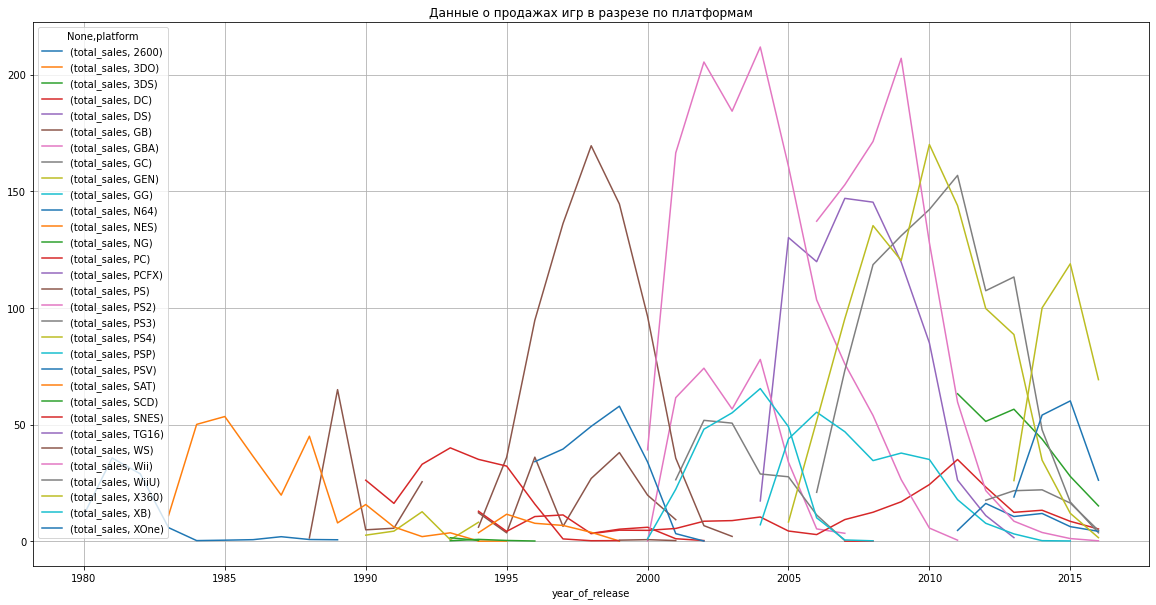

In [12]:
(games
.pivot_table(index=['platform', 'year_of_release'], values = ['total_sales'], aggfunc='sum')
.unstack('platform').plot(grid=True, figsize=(20, 10), title = 'Данные о продажах игр в разрезе по платформам'));

По графикам видно, что платформы, дойдя до своего пика продаж, начинают сбавлять обороты и постепенно угасают. Жизненный цикл одной платформы, примерно 10 лет (очень приближенно, просто визуально по графику).

In [13]:
games.groupby('year_of_release')['platform'].nunique()

year_of_release
1980     1
1981     1
1982     1
1983     2
1984     2
1985     4
1986     2
1987     2
1988     4
1989     3
1990     4
1991     4
1992     6
1993     5
1994    10
1995     8
1996     8
1997     6
1998     7
1999     8
2000     9
2001    10
2002     8
2003     6
2004     7
2005     8
2006    10
2007    11
2008     9
2009     7
2010     7
2011     9
2012     9
2013    11
2014    10
2015    10
2016     9
Name: platform, dtype: int64

C момента зарождения игровых платформ в 1980 году ежегодно продавала игры лишь одна платформа. В 1983 году появляется вторая платформа. И далее, с 1994 года платформ становится в среднем 10 на каждый год. 

### Данные по продажам игр по платформам

In [14]:
games.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales', ascending=False)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Без привязки к годам видно, что наибольший размер продаж у шести платформ: PS2, X360, PS3, Wii, DS, PS. 

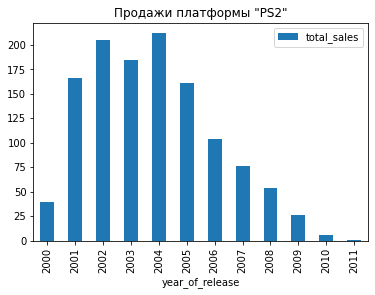

In [15]:
games.query('platform == "PS2"').groupby('year_of_release').agg({'total_sales':'sum'}).plot(kind='bar', title='Продажи платформы "PS2"');

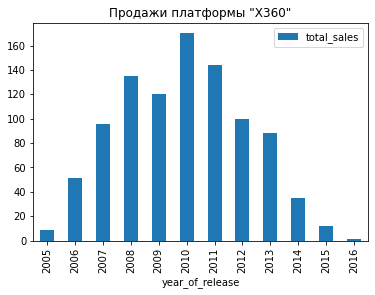

In [16]:
games.query('platform == "X360"').groupby('year_of_release').agg({'total_sales':'sum'}).plot(kind='bar', title='Продажи платформы "X360"');

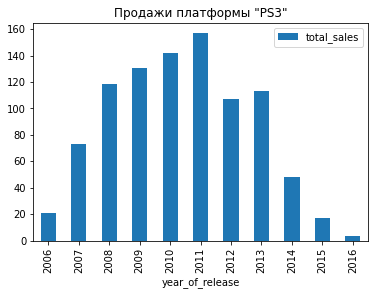

In [17]:
games.query('platform == "PS3"').groupby('year_of_release').agg({'total_sales':'sum'}).plot(kind='bar', title='Продажи платформы "PS3"');

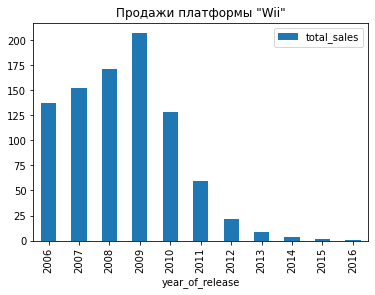

In [18]:
games.query('platform == "Wii"').groupby('year_of_release').agg({'total_sales':'sum'}).plot(kind='bar', title='Продажи платформы "Wii"');

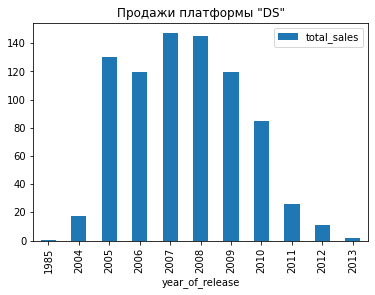

In [19]:
games.query('platform == "DS"').groupby('year_of_release').agg({'total_sales':'sum'}).plot(kind='bar', title='Продажи платформы "DS"');

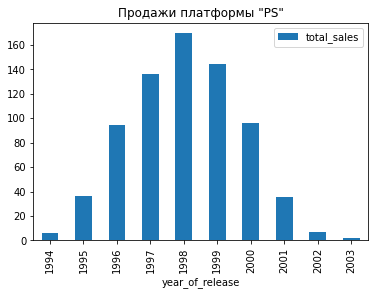

In [20]:
games.query('platform == "PS"').groupby('year_of_release').agg({'total_sales':'sum'}).plot(kind='bar', title='Продажи платформы "PS"');

На отдельных графиках по продажам каждой из шести наиболее успешных платформ видно, что предположение про средний срок работы платформы в 10 лет подтверждается. На самом деле у всех выделенных платформ срок жизни от 10 до 12 лет. Интересная компания "DS", которая вела деятельность в 1985 году, после чего был большой перерыв в работе, и в 2014 году они снова возродились, и проработали ещё 10 лет.

На своем пике компания находится 3-4 года, реже 5 лет. 

### Выбор актуального периода

В качестве актуального периода возьмем годы с 2013 по 2016. Во-первых, четыре года - примерно столько платформа зарабатывает свои основные деньги, она уже начала хорошо продаваться, и продажи ещё не пошли на спад. Во-вторых, в 2012 произошел спад продаж, по сравнению с 2011 годом, почти в два раза, хотя количество платформ осталось прежним. И с 2012 года начался как-будто новый этап в продажах игр, уже не настолько великий, как был с 2006 по 2011 годы. Возьмем из этого этапа последние 4 года. Создадим отдельную таблицу с данными только в актуальном для нас периоде.

In [21]:
games_current = games.query('year_of_release >= 2013')

In [22]:
games_current.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales', ascending=False)

,total_sales
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99
Wii,13.66


За актуальный период времени на игровом рынке было 11 платформ. Из них наибольший доход за эти годы имели следующие пять платформ: "PS4", "PS3', "XOne", "3DS", "X360". 

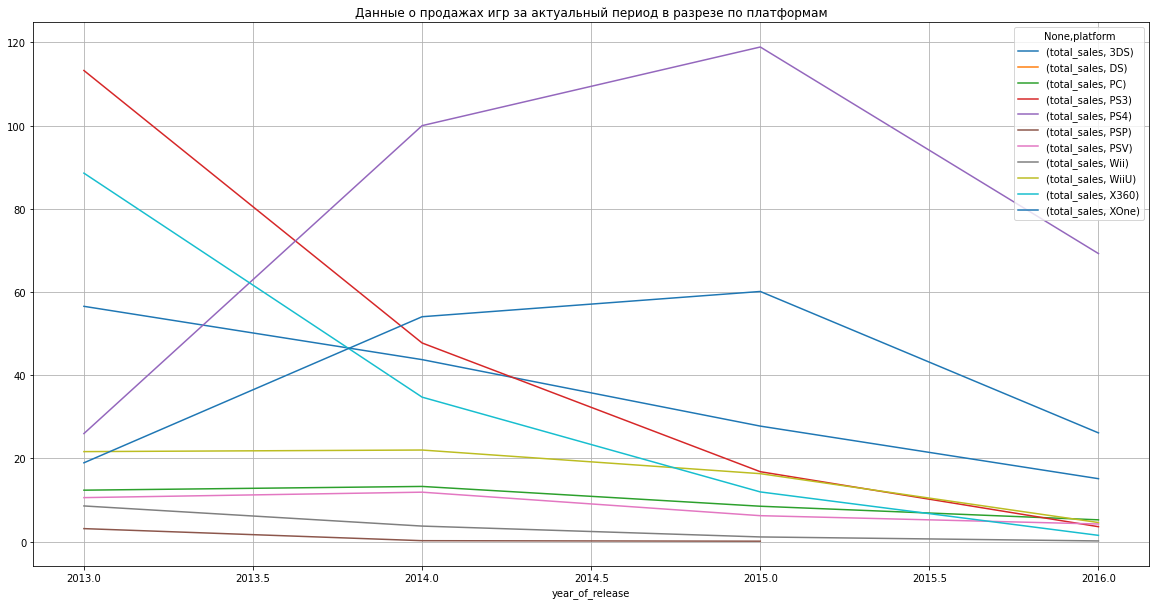

In [23]:
(games_current
.pivot_table(index=['platform', 'year_of_release'], values = ['total_sales'], aggfunc='sum')
.unstack('platform')
.plot(grid=True, figsize=(20, 10), title = 'Данные о продажах игр за актуальный период в разрезе по платформам'));

Не смотря на то, что за актуальный период лидируют пять выше написанных платформ, если посмотреть на 2016 год, они будут немного другими:

In [24]:
(games_current
 .query('year_of_release == 2016')
 .groupby('platform').agg({'total_sales':'sum'})
 .sort_values('total_sales', ascending=False))

,total_sales
platform,
PS4,69.25
XOne,26.15
3DS,15.14
PC,5.25
WiiU,4.60
PSV,4.25
PS3,3.60
X360,1.52
Wii,0.18


Поэтому рассмотрим по отдельности семь платформ: "PS4", "PS3', "XOne", "3DS", "X360", "PC", "WiiU".

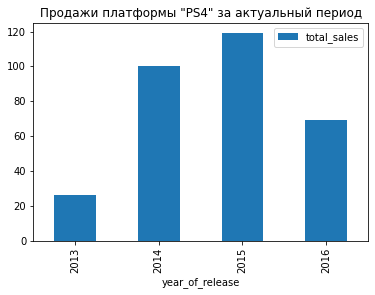

In [25]:
(games_current.query('platform == "PS4"')
 .groupby('year_of_release').agg({'total_sales':'sum'})
 .plot(kind='bar', title='Продажи платформы "PS4" за актуальный период'));

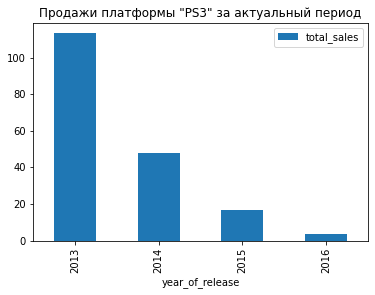

In [26]:
(games_current.query('platform == "PS3"')
 .groupby('year_of_release').agg({'total_sales':'sum'})
 .plot(kind='bar', title='Продажи платформы "PS3" за актуальный период'));

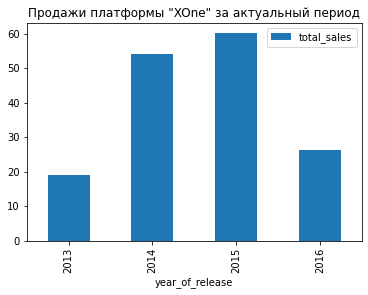

In [27]:
(games_current.query('platform == "XOne"')
 .groupby('year_of_release').agg({'total_sales':'sum'})
 .plot(kind='bar', title='Продажи платформы "XOne" за актуальный период'));

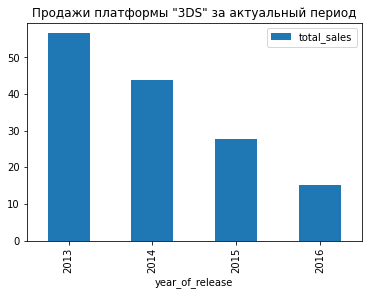

In [28]:
(games_current.query('platform == "3DS"')
 .groupby('year_of_release').agg({'total_sales':'sum'})
 .plot(kind='bar', title='Продажи платформы "3DS" за актуальный период'));

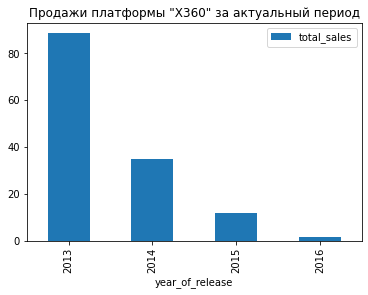

In [29]:
(games_current.query('platform == "X360"')
 .groupby('year_of_release').agg({'total_sales':'sum'})
 .plot(kind='bar', title='Продажи платформы "X360" за актуальный период'));

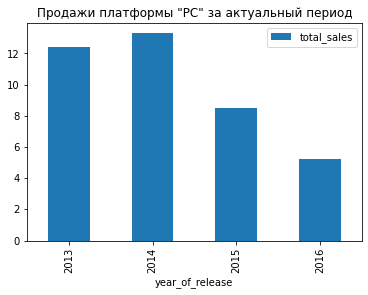

In [30]:
(games_current.query('platform == "PC"')
 .groupby('year_of_release').agg({'total_sales':'sum'})
 .plot(kind='bar', title='Продажи платформы "PC" за актуальный период'));

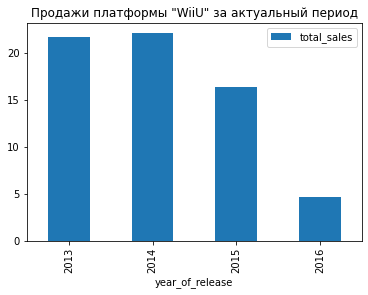

In [31]:
(games_current.query('platform == "WiiU"')
 .groupby('year_of_release').agg({'total_sales':'sum'})
 .plot(kind='bar', title='Продажи платформы "WiiU" за актуальный период'));

"XOne" и "PS4" начали работать в 2013 году и к концу нашего актуального периода как раз имеют пик продаж (думаю, что спад в 2016 году виден из-за отсутствия полных данных в 2016 году).

"3DS" начала свое существование до начала нашего актуального периода, имела ярко выраженного пика продаж и продолжает работать в 2016.

"PS3" от своего крутого пика спустились в 2016 году к продажам менее четырех миллионов копий, не будем брать их в расчёт. Такая же ситуация по "X360".

А платформы "WiiU" и "PC" показали в 2016 году неплохие продажи (чуть меньше пяти миллионов и чуть больше соответственно), поэтому понаблюдаем за ними ещё.

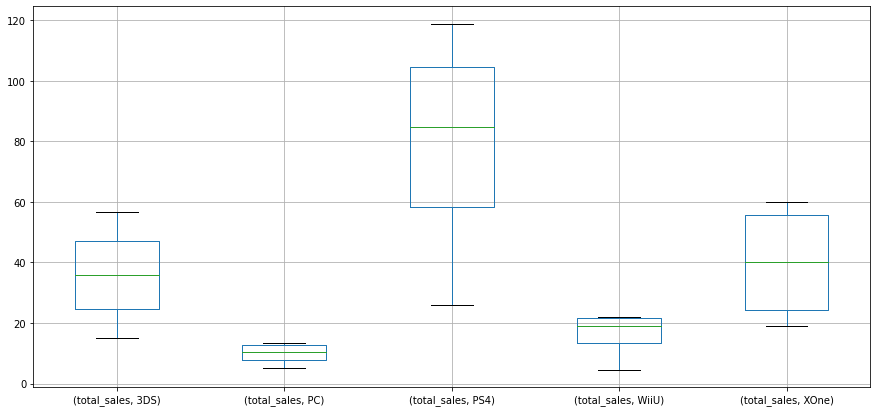

In [32]:
(games_current.query('platform == "XOne" or platform == "PS4" or platform == "3DS" or platform == "PC" or platform == "WiiU"')
.pivot_table(index=['platform', 'year_of_release'], values = ['total_sales'], aggfunc='sum')
.unstack('platform')
.boxplot(grid=True, figsize=(15, 7)));

Наиболее выигрышной платформой выглядит "PS4", медианное значение продаж больше 80 миллионов копий.

### Взаимосвязь продаж игр и отзывов

In [33]:
display('Корреляция между продажами и отзывами критиков для платформы PS4', 
        games_current.query('platform == "PS4"')[['total_sales', 'critic_score']].corr())
display('Корреляция между продажами и отзывами пользователей для платформы PS4', 
        games_current.query('platform == "PS4"')[['total_sales', 'user_score']].corr())

'Корреляция между продажами и отзывами критиков для платформы PS4'

,total_sales,critic_score
total_sales,1.000000,0.406568
critic_score,0.406568,1.000000


'Корреляция между продажами и отзывами пользователей для платформы PS4'

,total_sales,user_score
total_sales,1.000000,-0.027428
user_score,-0.027428,1.000000


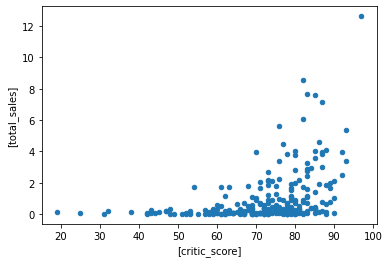

In [34]:
games_current.query('platform == "PS4"').plot(x=['critic_score'], y=['total_sales'], kind='scatter');

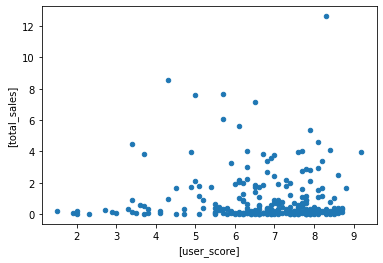

In [35]:
games_current.query('platform == "PS4"').plot(x=['user_score'], y=['total_sales'], kind='scatter');

Зависимость между отзывами критиков и продажами есть, но очень маленькая, на диаграмме рассеяния эту связь почти не видно. А вот зависимости между продажами и отзывами пользователей нет никакой. Проверим это на оставшихся двух платформах.

In [36]:
display('Корреляция между продажами и отзывами критиков для платформы 3DS', 
        games_current.query('platform == "3DS"')[['total_sales', 'critic_score']].corr())
display('Корреляция между продажами и отзывами пользователей для платформы 3DS', 
        games_current.query('platform == "3DS"')[['total_sales', 'user_score']].corr())

'Корреляция между продажами и отзывами критиков для платформы 3DS'

,total_sales,critic_score
total_sales,1.000000,0.357057
critic_score,0.357057,1.000000


'Корреляция между продажами и отзывами пользователей для платформы 3DS'

,total_sales,user_score
total_sales,1.000000,0.255738
user_score,0.255738,1.000000


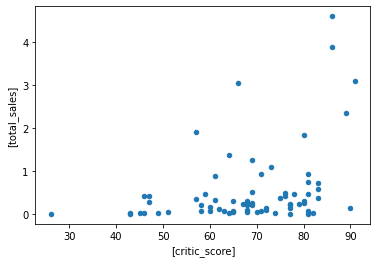

In [37]:
games_current.query('platform == "3DS"').plot(x=['critic_score'], y=['total_sales'], kind='scatter');

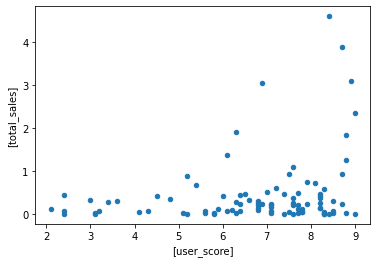

In [38]:
games_current.query('platform == "3DS"').plot(x=['user_score'], y=['total_sales'], kind='scatter');

In [39]:
display('Корреляция между продажами и отзывами критиков для платформы XOne', 
        games_current.query('platform == "XOne"')[['total_sales', 'critic_score']].corr())
display('Корреляция между продажами и отзывами пользователей для платформы XOne', 
        games_current.query('platform == "XOne"')[['total_sales', 'user_score']].corr())

'Корреляция между продажами и отзывами критиков для платформы XOne'

,total_sales,critic_score
total_sales,1.000000,0.416998
critic_score,0.416998,1.000000


'Корреляция между продажами и отзывами пользователей для платформы XOne'

,total_sales,user_score
total_sales,1.000000,-0.070505
user_score,-0.070505,1.000000


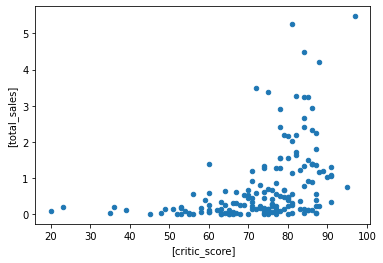

In [40]:
games_current.query('platform == "XOne"').plot(x=['critic_score'], y=['total_sales'], kind='scatter');

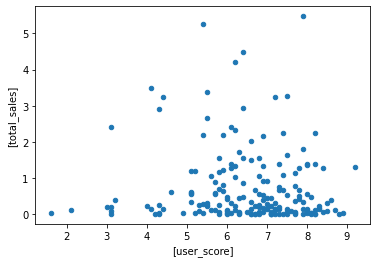

In [41]:
games_current.query('platform == "XOne"').plot(x=['user_score'], y=['total_sales'], kind='scatter');

In [42]:
display('Корреляция между продажами и отзывами критиков для платформы WiiU', 
        games_current.query('platform == "WiiU"')[['total_sales', 'critic_score']].corr())
display('Корреляция между продажами и отзывами пользователей для платформы WiiU', 
        games_current.query('platform == "WiiU"')[['total_sales', 'user_score']].corr())

'Корреляция между продажами и отзывами критиков для платформы WiiU'

,total_sales,critic_score
total_sales,1.000000,0.376415
critic_score,0.376415,1.000000


'Корреляция между продажами и отзывами пользователей для платформы WiiU'

,total_sales,user_score
total_sales,1.000000,0.417299
user_score,0.417299,1.000000


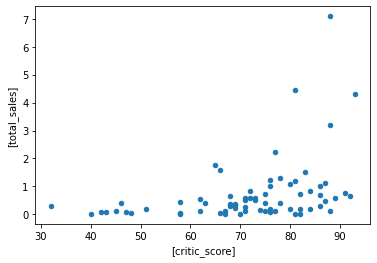

In [43]:
games_current.query('platform == "WiiU"').plot(x=['critic_score'], y=['total_sales'], kind='scatter');

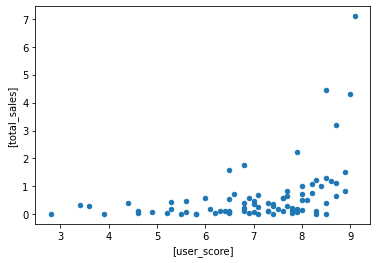

In [44]:
games_current.query('platform == "WiiU"').plot(x=['user_score'], y=['total_sales'], kind='scatter');

In [45]:
display('Корреляция между продажами и отзывами критиков для платформы PC', 
        games_current.query('platform == "PC"')[['total_sales', 'critic_score']].corr())
display('Корреляция между продажами и отзывами пользователей для платформы PC', 
        games_current.query('platform == "PC"')[['total_sales', 'user_score']].corr())

'Корреляция между продажами и отзывами критиков для платформы PC'

,total_sales,critic_score
total_sales,1.00000,0.19603
critic_score,0.19603,1.00000


'Корреляция между продажами и отзывами пользователей для платформы PC'

,total_sales,user_score
total_sales,1.000000,-0.097723
user_score,-0.097723,1.000000


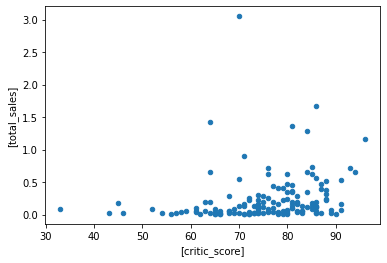

In [46]:
games_current.query('platform == "PC"').plot(x=['critic_score'], y=['total_sales'], kind='scatter');

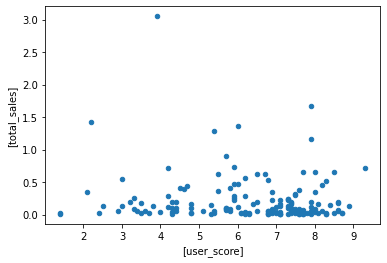

In [47]:
games_current.query('platform == "PC"').plot(x=['user_score'], y=['total_sales'], kind='scatter');

У всех рассматриваемых платформ имеется некоторая зависимость продаж от отзывов критиков, у платформы "РС" эта связь ниже, чем у остальных (но у всех остальных тоже не особо высока. У платформ "3DS" и "WiiU" имеется прямая зависимость продаж от отзывов пользователей, у остальных платформ эта связь близка к нулю.

### Общее распределение игр по жанрам

'Количество продаж игр в зависимости от жанра за актуальный период'

,total_sales
genre,
Action,321.87
Shooter,232.98
Sports,150.65
Role-Playing,145.89
Misc,62.82
Platform,42.63
Racing,39.89
Fighting,35.31
Adventure,23.64


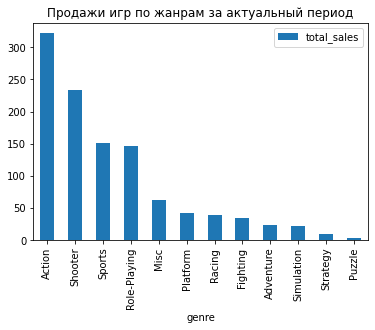

In [48]:
display('Количество продаж игр в зависимости от жанра за актуальный период', 
        games_current.groupby('genre').agg({'total_sales':'sum'}).sort_values('total_sales', ascending=False))
(games_current.groupby('genre')
 .agg({'total_sales':'sum'}).sort_values('total_sales', ascending=False)
 .plot(kind='bar', title='Продажи игр по жанрам за актуальный период'));

'Медианное количество продаж игр в зависимости от жанра за актуальный период'

,total_sales
genre,
Shooter,0.450
Sports,0.240
Platform,0.225
Role-Playing,0.125
Fighting,0.125
Racing,0.120
Action,0.110
Simulation,0.100
Misc,0.100


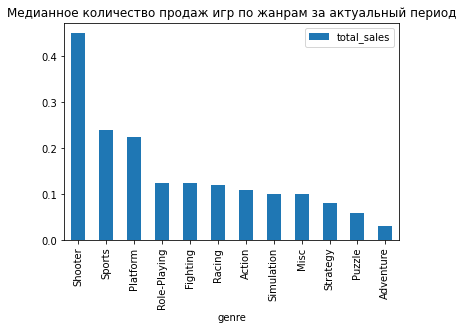

In [49]:
display('Медианное количество продаж игр в зависимости от жанра за актуальный период', 
        games_current.groupby('genre').agg({'total_sales':'median'}).sort_values('total_sales', ascending=False))
(games_current.groupby('genre')
 .agg({'total_sales':'median'}).sort_values('total_sales', ascending=False)
 .plot(kind='bar', title='Медианное количество продаж игр по жанрам за актуальный период'));

'Среднее количество продаж игр в зависимости от жанра за актуальный период'

,total_sales
genre,
Shooter,1.245882
Sports,0.703972
Platform,0.576081
Role-Playing,0.499623
Racing,0.469294
Fighting,0.441375
Action,0.420196
Misc,0.405290
Simulation,0.350968


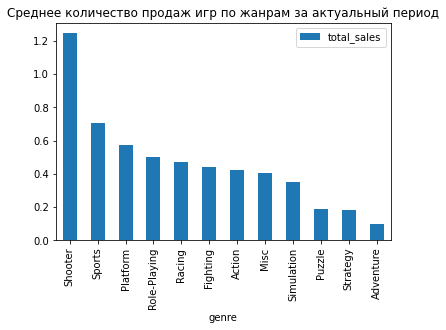

In [50]:
display('Среднее количество продаж игр в зависимости от жанра за актуальный период', 
        games_current.groupby('genre').agg({'total_sales':'mean'}).sort_values('total_sales', ascending=False))
(games_current.groupby('genre')
 .agg({'total_sales':'mean'}).sort_values('total_sales', ascending=False)
 .plot(kind='bar', title='Среднее количество продаж игр по жанрам за актуальный период'));

Общее количество проданных игр наибольшее у жанра Экшн, но за высокими показателями общих продаж может скрываться множество мелких игр с низкими продажами. Поэтому обратим внимание на медианное и среднее количество проданных игр за актуальных период в разрезе по жанрам. 

Если смотреть на медианное или среднее значение, то жанр Экшн там только на седьмом месте, а самые актуальные игры - это Shooter, Sports, Platform, Role-Playing, Racing. Вообще, наиболее популярные жанры - это первые три (Shooter, Sports, Platform), а следом за ними не сильно различимые Role-Playing, Fighting, Racing, Action, Simulation, Misc.

## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5)

In [51]:
(games_current.groupby('platform')
 .agg({'na_sales':'sum'}).sort_values('na_sales', ascending=False).head())

,na_sales
platform,
PS4,108.74
XOne,93.12
X360,81.66
PS3,63.50
3DS,38.20


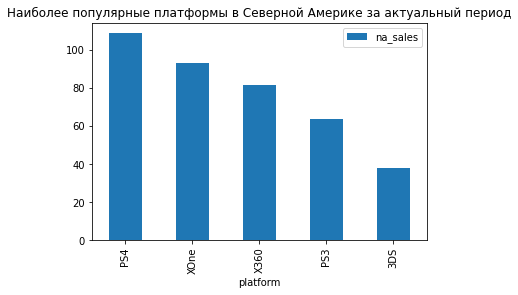

In [52]:
(games_current.groupby('platform')
 .agg({'na_sales':'sum'}).sort_values('na_sales', ascending=False).head()
.plot(kind='bar', title='Наиболее популярные платформы в Северной Америке за актуальный период'));

In [53]:
(games_current.groupby('platform')
 .agg({'eu_sales':'sum'}).sort_values('eu_sales', ascending=False).head())

,eu_sales
platform,
PS4,141.09
PS3,67.81
XOne,51.59
X360,42.52
3DS,30.96


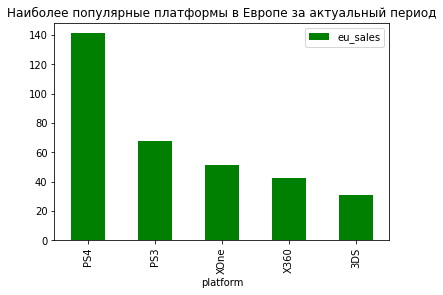

In [54]:
(games_current.groupby('platform')
 .agg({'eu_sales':'sum'}).sort_values('eu_sales', ascending=False).head()
.plot(kind='bar', color='green', title='Наиболее популярные платформы в Европе за актуальный период'));

In [55]:
(games_current.groupby('platform')
 .agg({'jp_sales':'sum'}).sort_values('jp_sales', ascending=False).head())

,jp_sales
platform,
3DS,67.81
PS3,23.35
PSV,18.59
PS4,15.96
WiiU,10.88


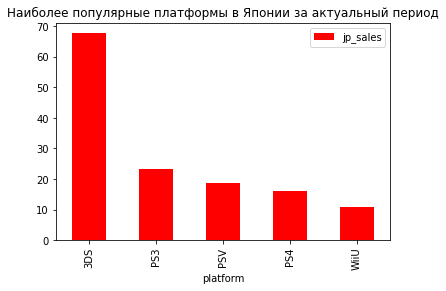

In [56]:
(games_current.groupby('platform')
 .agg({'jp_sales':'sum'}).sort_values('jp_sales', ascending=False).head()
.plot(kind='bar', color='red', title='Наиболее популярные платформы в Японии за актуальный период'));

In [57]:
(games_current.groupby('platform')
 .agg({'other_sales':'sum'}).sort_values('other_sales', ascending=False).head())

,other_sales
platform,
PS4,48.35
PS3,26.77
XOne,14.27
X360,12.11
3DS,6.28


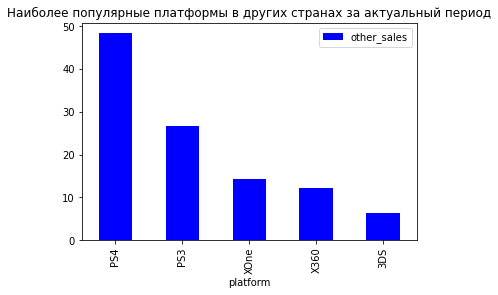

In [58]:
(games_current.groupby('platform')
 .agg({'other_sales':'sum'}).sort_values('other_sales', ascending=False).head()
.plot(kind='bar', color='blue', title='Наиболее популярные платформы в других странах за актуальный период'));

Топ-5 популярных платформ Европы и других стран совпадает, в Северной Америке лидируют те же платформы, но в другом порядке. А вот Японии данные по платформам отличаются от остального мира. Там лидирует платформа 3DS, которая представлена в Топ-5 всех остальных групп стран, но стоит везде на последнем, пятом месте. Так же в японском рейтинге платформ отсутствуют платформы X360 (занимающая третье место в Северной Америке) и XOne (занимающая второе место в Северной Америке).

Распределение популярных платформ по Северной Америке и Европе очень схожи: самая популярная платформа продавала около 140 миллионов копий за актуальный период, а пятая в рейтинге платформа продавала около 50 миллионов копий за тот же период. Продажи на самых популярных платформах Японии и остальных стран, конечно, ниже американских и европейских.

### Самые популярные жанры для каждого региона (топ-5)

In [59]:
(games_current.groupby('genre')
 .agg({'na_sales':'sum'}).sort_values('na_sales', ascending=False).head())

,na_sales
genre,
Action,126.05
Shooter,109.74
Sports,65.27
Role-Playing,46.40
Misc,27.49


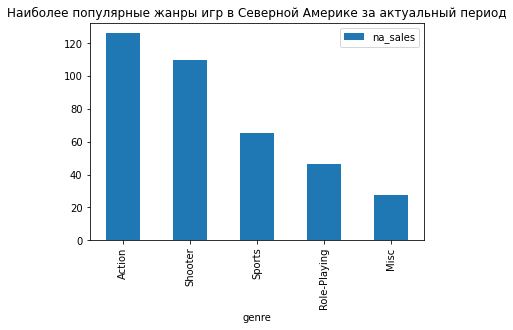

In [60]:
(games_current.groupby('genre')
 .agg({'na_sales':'sum'}).sort_values('na_sales', ascending=False).head()
.plot(kind='bar', title='Наиболее популярные жанры игр в Северной Америке за актуальный период'));

In [61]:
(games_current.groupby('genre')
 .agg({'eu_sales':'sum'}).sort_values('eu_sales', ascending=False).head())

,eu_sales
genre,
Action,118.13
Shooter,87.86
Sports,60.52
Role-Playing,36.97
Racing,20.19


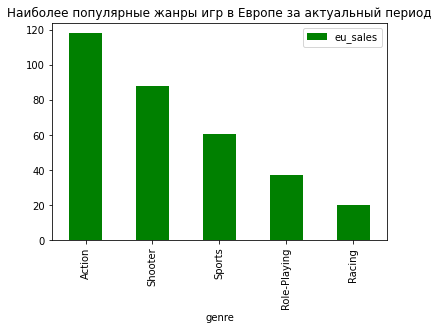

In [62]:
(games_current.groupby('genre')
 .agg({'eu_sales':'sum'}).sort_values('eu_sales', ascending=False).head()
.plot(kind='bar', color='green', title='Наиболее популярные жанры игр в Европе за актуальный период'));

In [63]:
(games_current.groupby('genre')
 .agg({'jp_sales':'sum'}).sort_values('jp_sales', ascending=False).head())

,jp_sales
genre,
Role-Playing,51.04
Action,40.49
Misc,9.20
Fighting,7.65
Shooter,6.61


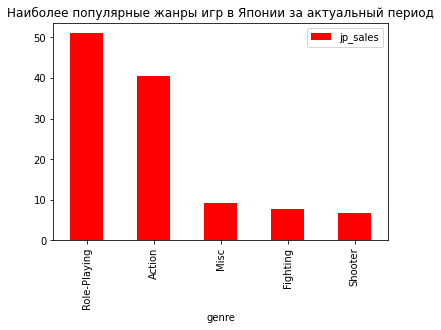

In [64]:
(games_current.groupby('genre')
 .agg({'jp_sales':'sum'}).sort_values('jp_sales', ascending=False).head()
.plot(kind='bar', color='red', title='Наиболее популярные жанры игр в Японии за актуальный период'));

In [65]:
(games_current.groupby('genre')
 .agg({'other_sales':'sum'}).sort_values('other_sales', ascending=False).head())

,other_sales
genre,
Action,37.20
Shooter,28.77
Sports,19.45
Role-Playing,11.48
Misc,6.09


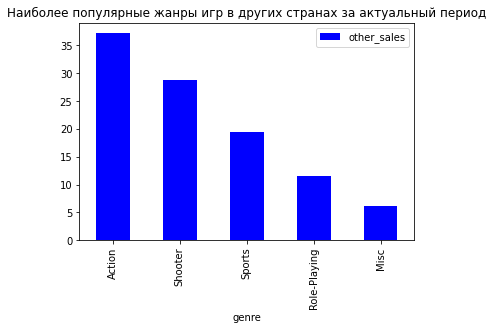

In [66]:
(games_current.groupby('genre')
 .agg({'other_sales':'sum'}).sort_values('other_sales', ascending=False).head()
.plot(kind='bar', color='blue', title='Наиболее популярные жанры игр в других странах за актуальный период'));

По жанрам видим опять сильное отличие Японии. Если в странах Северной Америки, Европы и других лидирует игровой жанр Action, то в Японии лидируют Role-Playing. Четыре первых места в Северной Америке, Европе и других странах распределились так: Action, Shooter, Sports, Role-Playing. Пятое место занимают Misc или Racing. В Японии же после ролевых игр идут Action, Misc, Simulation и Fighting.	

### Влияние рейтинга ERSB

Entertainment Software Rating Board предоставляет следующие рейтинги и соответствующие возрастные категории:

«EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры. Некоторые усложнённые развивающие игры могут иметь рейтинг «Everyone».

«E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первой игрой, которая получила данный рейтинг, стала The Simpsons Cartoon Studio, выпущенная в 1996 году. Первоначально "K-A" ("Kids to Adults")

«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года. Первой игрой, которая получила данный рейтинг, стала Donkey Kong: Jungle Beat.

«T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

«M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

«AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое, а также сцены с обнажением. Большинство таких игр предназначено для персональных компьютеров под управлением Microsoft Windows и Apple Macintosh. Рейтинг «Только для взрослых» является предметом многочисленных дискуссий, так как накладывает серьёзные ограничения на продажи игры. Первой игрой, которая получила данный рейтинг, стала The Joy of Sex, выпущенная в 1993 году.

«RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу.

«K-A» для детей и взрослых: Игры, содержащие контент, подходящий для широкой аудитории. Этот рейтинг использовался до 1998 года, когда он был переименован в «Е».

Данные мы будем брать только за актуальный период.

In [67]:
games_current['rating'].isna().sum()

977

In [68]:
games_current['rating'] = games_current['rating'].fillna('undefined')

In [69]:
games_current.groupby('rating')['rating'].nunique()

rating
E            1
E10+         1
M            1
T            1
undefined    1
Name: rating, dtype: int64

Я заменила все пропущенные значения в столбце с рейтингом на значение "undefined". В актуальном периоде продавались игры только четырех возрастных категорий: "для всех", "для всех от 10 лет", "для взрослых" и "для подростков (от 13 лет)". Для детей игры не продавались.

In [70]:
(games_current.groupby('rating')
 .agg({'na_sales':'sum'}).sort_values('na_sales', ascending=False))

,na_sales
rating,
M,165.21
undefined,89.42
E,79.05
E10+,54.24
T,49.79


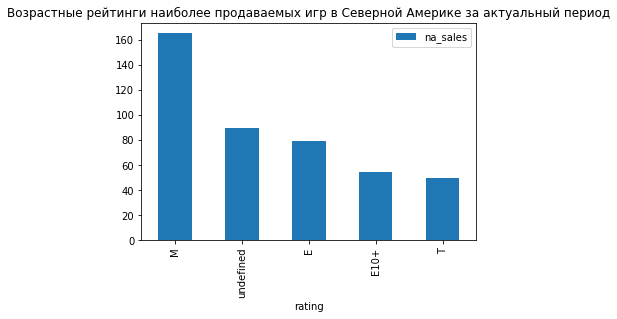

In [71]:
(games_current.groupby('rating')
 .agg({'na_sales':'sum'}).sort_values('na_sales', ascending=False)
.plot(kind='bar', title='Возрастные рейтинги наиболее продаваемых игр в Северной Америке за актуальный период'));

In [72]:
(games_current.groupby('rating')
 .agg({'eu_sales':'sum'}).sort_values('eu_sales', ascending=False))

,eu_sales
rating,
M,145.32
E,83.36
undefined,78.91
E10+,42.69
T,41.95


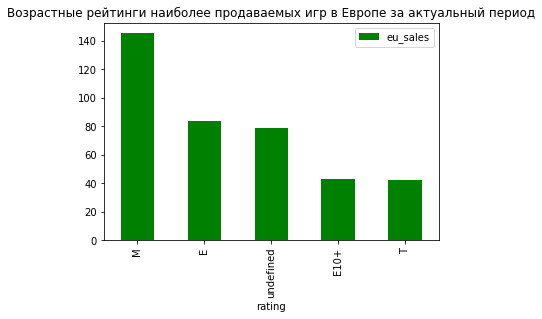

In [73]:
(games_current.groupby('rating')
 .agg({'eu_sales':'sum'}).sort_values('eu_sales', ascending=False)
.plot(kind='bar', color='green', title='Возрастные рейтинги наиболее продаваемых игр в Европе за актуальный период'));

In [74]:
(games_current.groupby('rating')
 .agg({'jp_sales':'sum'}).sort_values('jp_sales', ascending=False))

,jp_sales
rating,
undefined,85.05
T,20.59
E,15.14
M,14.11
E10+,5.89


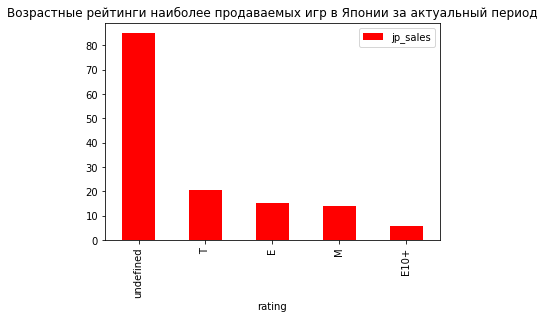

In [75]:
(games_current.groupby('rating')
 .agg({'jp_sales':'sum'}).sort_values('jp_sales', ascending=False)
.plot(kind='bar', color='red', title='Возрастные рейтинги наиболее продаваемых игр в Японии за актуальный период'));

In [76]:
(games_current.groupby('rating')
 .agg({'other_sales':'sum'}).sort_values('other_sales', ascending=False))

,other_sales
rating,
M,47.04
undefined,23.46
E,22.61
T,14.29
E10+,12.57


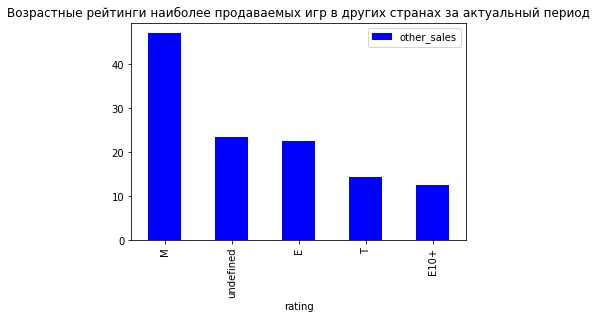

In [77]:
(games_current.groupby('rating')
 .agg({'other_sales':'sum'}).sort_values('other_sales', ascending=False)
.plot(kind='bar', color='blue', title='Возрастные рейтинги наиболее продаваемых игр в других странах за актуальный период'));

В Северной Америке, Европе и других странах лидируют игры возрастной категории "для взрослых", на втором месте стоят либо игры с категорией "для всех", либо игры, у которых был не указан возрастной рейтинг. А два последних места делят между собой игры "для тинейджеров" и "для всех от 10 лет". В Японии ситуация немного другая: чаще всего продаются игры с неопределенной категорией по возрасту, всех остальных игр продается гораздо меньше.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза - средние пользовательские рейтинги платформ XOne и PC равны. 

Альтернативная гипотеза - средние пользовательский рейтинги платформ XOne и PC не равны.

Проверим гипотезу с помощью t-теста.

In [78]:
XOne = games_current.query('platform == "XOne"')['user_score']
PC = games_current.query('platform == "PC"')['user_score'] 

alpha = .05 
results = st.ttest_ind(XOne, PC, equal_var=False, nan_policy='omit')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")  

p-значение:  0.16097023533449004
Не получилось отвергнуть нулевую гипотезу


In [79]:
display('Средний пользовательский рейтинг игр на платформе XOne', games_current.query('platform == "XOne"')['user_score'].mean())
display('Средний пользовательский рейтинг игр на платформе PC', games_current.query('platform == "PC"')['user_score'].mean())

'Средний пользовательский рейтинг игр на платформе XOne'

6.524864864864864

'Средний пользовательский рейтинг игр на платформе PC'

6.282692307692307

Таким образом, гипотезу о том что на рассмотренных двух платформах средний пользовательский рейтинг одинаков, отвергнуть не получилось.

### Средние пользовательские рейтинги жанров Action и Sports разные

Нулевая гипотеза - средние пользовательские рейтинги игр жанров Action и Sports равны.

Альтернативная гипотеза - средние пользовательские рейтинги игр жанров Action и Sports не равны.

Проверим гипотезу с помощью t-теста.

In [80]:
action = games_current.query('genre == "Action"')['user_score']
sports = games_current.query('genre == "Sports"')['user_score']

alpha = .05 
results = st.ttest_ind(action, sports, equal_var=False, nan_policy='omit')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  7.631940781789286e-19
Отвергаем нулевую гипотезу


In [81]:
display('Средний пользовательский рейтинг игр жанра Action', games_current.query('genre == "Action"')['user_score'].mean())
display('Средний пользовательский рейтинг игр жанра Sports', games_current.query('genre == "Sports"')['user_score'].mean())

'Средний пользовательский рейтинг игр жанра Action'

6.806862745098039

'Средний пользовательский рейтинг игр жанра Sports'

5.290853658536585

Таким образом, гипотезу о том, что средние пользовательские рейтинги игр жанров Action и Sports равны, отвергаем. Принимаем альтернативную гипотезу, эти рейтинги не равны.

## Вывод

Учитывая название интернет-магазина, вероятно, этот магазин работает в России. Скорее всего Россию относят к категории other (либо к Европе, но данные там похожи). На основании проведенного анализа можно посоветовать интернет-магазину "Стримчик" рекламировать игры для взрослых жанра Экшн или Шутер, реализуемые на платформе PS4. При этом оценка критиков иногда может оказывать некоторое влияние на популярность игры, поэтому можно обратить внимание на игры с высокой оценкой критиков. 

Например, в 2015 - 2016 году по этим критериям подходили следующие игры:

In [82]:
games_current.query('platform == "PS4" and rating == "M" and (genre == "Action" or genre =="Shooter") and year_of_release >= 2015 and critic_score >= 85')['name']

289                            Battlefield 1
305                    Batman: Arkham Knight
390     Metal Gear Solid V: The Phantom Pain
623                               Bloodborne
2718                             Titanfall 2
3157                            Dishonored 2
Name: name, dtype: object

Так же можно обратить внимание на другие жанры: спортивные соревнования и платформенные игры, другие платформы: PS3, X360 и XOne, и игры без указания возрастного рейтинга.